# Segmenting and Clustering Neighborhoods in Toronto 

### Introduction

In this exploratory data analysis project, we will explore, segment, and cluster the neighborhoods in the city of Toronto, Canada based on the postalcode and borough information. We will scrape a Wikipedia page using Beautiful Soup library and wrangle the data, clean it, and then read it into a pandas  dataframe. We will use the explore function in foursquare API to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters.  Cluster analysis of neighborhoods will be performed by k-means clustering algorithm. Finally, we will use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.



### Table of Contents

#### 1. Scrap Toronto data from Wikipedia web page

#### 2. Explore Neighborhoods in Toronto

#### 3. Analyze Each Neighborhood

#### 4. Cluster Neighborhoods

#### 5. Examine Clusters




Import necessary Libraries and modules

In [3]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 

from bs4 import BeautifulSoup

#### 1. Scrap Toronto data from Wikipedia web page

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

We use get to download the contents of the webpage in text format and store in a variable called data.

In [5]:
data  = requests.get(url).text 

We create a BeautifulSoup object using the BeautifulSoup constructor

In [6]:
soup = BeautifulSoup(data,"html5lib")

In [7]:
table_content=[]
table=soup.find('table')

In [8]:
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_content.append(cell)

Tranform the data into a pandas dataframe

In [9]:
Toronto_neighborhoods=pd.DataFrame(table_content)

In [10]:

Toronto_neighborhoods['Borough']=Toronto_neighborhoods['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

Quickly examine the resulting dataframe.

In [11]:
Toronto_neighborhoods.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Get the latitude and longitude values of Toronto

In [12]:
coordinates = pd.read_csv('Geospatial_Coordinates.csv')

In [13]:
Latitude = coordinates['Latitude']
Longitude = coordinates['Longitude']

In [14]:
Toronto_neighborhoods['Latitude'] = Latitude
Toronto_neighborhoods['Longitude'] = Longitude

Re-examine the resulting dataframe which includes Latitudes and Longitudes.

In [15]:
Toronto_neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.806686,-79.194353
1,M4A,North York,Victoria Village,43.784535,-79.160497
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.770992,-79.216917
4,M7A,Queen's Park,Ontario Provincial Government,43.773136,-79.239476


Let's check the number of rows and columns in the dataframe.

In [16]:
Toronto_neighborhoods.shape

(103, 5)

Let's get the geograpical coordinates of Toronto

In [17]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_neighborhoods['Latitude'], Toronto_neighborhoods['Longitude'], Toronto_neighborhoods['Borough'], Toronto_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Let's simplify the above map and segment and cluster only the neighborhoods in Downtown Toronto. So let's slice the original dataframe and create a new dataframe of the Downtown Toronto data.

In [19]:
D_Toronto_data = Toronto_neighborhoods[Toronto_neighborhoods['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
D_Toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.692657,-79.264848
2,M5C,Downtown Toronto,St. James Town,43.799525,-79.318389
3,M5E,Downtown Toronto,Berczy Park,43.757490,-79.374714
4,M5G,Downtown Toronto,Central Bay Street,43.782736,-79.442259


Let's get the geographical coordinates of Downtown Toronto.

In [20]:
address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.6563221, -79.3809161.


As we did with all of Toronto, let's visualize the Downtown Toronto neighborhoods in it.

In [21]:
# create map of Downtown Toronto using latitude and longitude values
map_D_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(D_Toronto_data['Latitude'], D_Toronto_data['Longitude'], D_Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_D_Toronto)  
    
map_D_Toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

Define Foursquare Credentials and Version

In [22]:
CLIENT_ID = 'TVLBCGAELCWQFC1M4DQG4V5DWZDPGZZCJMO2KN3D5EDE1AVT' 
CLIENT_SECRET = '5N5ZIQYECVTYBHLS4MRF2UZHVYOBOSQV2S1I45CMJSZ330RW' 
VERSION = '20180605' 
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TVLBCGAELCWQFC1M4DQG4V5DWZDPGZZCJMO2KN3D5EDE1AVT
CLIENT_SECRET:5N5ZIQYECVTYBHLS4MRF2UZHVYOBOSQV2S1I45CMJSZ330RW



Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [23]:
D_Toronto_data.loc[0, 'Neighborhood']

'Regent Park, Harbourfront'

Get the neighborhood's latitude and longitude values.

In [24]:
neighborhood_latitude = D_Toronto_data.loc[0, 'Latitude'] 
neighborhood_longitude = D_Toronto_data.loc[0, 'Longitude'] 

neighborhood_name = D_Toronto_data.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.7635726, -79.1887115.


Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL url.

In [25]:
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=TVLBCGAELCWQFC1M4DQG4V5DWZDPGZZCJMO2KN3D5EDE1AVT&client_secret=5N5ZIQYECVTYBHLS4MRF2UZHVYOBOSQV2S1I45CMJSZ330RW&v=20180605&ll=43.7635726,-79.1887115&radius=500&limit=100'

Send the GET request and examine the resutls

In [26]:
results = requests.get(url).json()

Create a function that extracts the category of the venue

In [27]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [28]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-28-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,RBC Royal Bank,Bank,43.766790,-79.191151
1,G & G Electronics,Electronics Store,43.765309,-79.191537
2,Sail Sushi,Restaurant,43.765951,-79.191275
3,Big Bite Burrito,Mexican Restaurant,43.766299,-79.190720
4,Enterprise Rent-A-Car,Rental Car Location,43.764076,-79.193406


Let's check the number of venues returned by Foursquare.

In [29]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


#### 2. Explore Neighborhoods in Downtown Toronto

Let's create a function to repeat the same process to all the neighborhoods in Downtown Toronto

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

write the code to run the above function on each neighborhood and create a new dataframe called Downtown_toronto_venues.

In [31]:
Downtown_Toronto_venues = getNearbyVenues(names=D_Toronto_data['Neighborhood'],
                                   latitudes=D_Toronto_data['Latitude'],
                                   longitudes=D_Toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


Let's check the size of the resulting dataframe

In [32]:
print(Downtown_Toronto_venues.shape)
Downtown_Toronto_venues.head()

(136, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
1,"Regent Park, Harbourfront",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
2,"Regent Park, Harbourfront",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant
3,"Regent Park, Harbourfront",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
4,"Regent Park, Harbourfront",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location


Let's check how many venues were returned for each neighborhood

In [33]:
Downtown_Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,6,6,6,6,6,6
Christie,3,3,3,3,3,3
Church and Wellesley,9,9,9,9,9,9
"First Canadian Place, Underground city",1,1,1,1,1,1
"Garden District, Ryerson",5,5,5,5,5,5
"Harbourfront East, Union Station, Toronto Islands",5,5,5,5,5,5
"Kensington Market, Chinatown, Grange Park",33,33,33,33,33,33
"Regent Park, Harbourfront",9,9,9,9,9,9


Let's find out how many unique categories can be curated from all the returned venues

In [34]:
print('There are {} uniques categories.'.format(len(Downtown_Toronto_venues['Venue Category'].unique())))

There are 69 uniques categories.


### 3. Analyze Each Neighborhood

In [36]:
# one hot encoding
Downtown_Toronto_onehot = pd.get_dummies(Downtown_Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Downtown_Toronto_onehot['Neighborhood'] = Downtown_Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Downtown_Toronto_onehot.columns[-1]] + list(Downtown_Toronto_onehot.columns[:-1])
Downtown_Toronto_onehot = Downtown_Toronto_onehot[fixed_columns]

Downtown_Toronto_onehot.head()

,Neighborhood,Airport,Auto Workshop,Bank,Bar,Baseball Field,Beer Store,Board Shop,Breakfast Spot,Brewery,Burrito Place,Business Service,Café,Camera Store,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Comic Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Truck,French Restaurant,Garden,Garden Center,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Medical Center,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,Nail Salon,Park,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Sandwich Place,Skate Park,Skating Rink,Smoke Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Vegetarian / Vegan Restaurant,Yoga Studio
0,"Regent Park, Harbourfront",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [37]:
Downtown_Toronto_onehot.shape

(136, 70)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [38]:
Downtown_Toronto_grouped = Downtown_Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Downtown_Toronto_grouped

,Neighborhood,Airport,Auto Workshop,Bank,Bar,Baseball Field,Beer Store,Board Shop,Breakfast Spot,Brewery,Burrito Place,Business Service,Café,Camera Store,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Comic Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Truck,French Restaurant,Garden,Garden Center,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Medical Center,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,Nail Salon,Park,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Sandwich Place,Skate Park,Skating Rink,Smoke Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Vegetarian / Vegan Restaurant,Yoga Studio
0,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.058824,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.058824,0.058824,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.058824,0.058824,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.058824,0.0,0.000000,0.000000,0.000000,0.058824,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,0.0,0.058824,0.0,0.000000,0.000000,0.000000,0.000000,0.058824
1,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.166667,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.000000
2,Christie,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.111111,0.0,0.111111,0.0,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.0,0.0000,0.000000,0.000000,0.222222,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,"First Canadian Place, Underground city",0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Garden District, Ryerson",0.000000,0.000000,0.000000,0.000000,0.0

Let's confirm the new size

In [39]:
Downtown_Toronto_grouped.shape

(15, 70)

Let's print each neighborhood along with the top 5 most common venues

In [40]:
num_top_venues = 5

for hood in Downtown_Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Downtown_Toronto_grouped[Downtown_Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2       Garden Center  0.06
3                Park  0.06
4         Pizza Place  0.06


----Central Bay Street----
            venue  freq
0   Grocery Store  0.17
1     Coffee Shop  0.17
2        Pharmacy  0.17
3     Pizza Place  0.17
4  Discount Store  0.17


----Christie----
                  venue  freq
0                  Park  0.33
1     Food & Drink Shop  0.33
2  Fast Food Restaurant  0.33
3    Light Rail Station  0.00
4         Movie Theater  0.00


----Church and Wellesley----
            venue  freq
0     Pizza Place  0.22
1  Sandwich Place  0.11
2  Discount Store  0.11
3    Intersection  0.11
4      Playground  0.11


----First Canadian Place, Underground city----
                venue  freq
0      Baseball Field   1.0
1             Airport   0.0
2  Light Rail Station   0.0
3        

Let's put the most common venues into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Downtown_Toronto_grouped['Neighborhood']

for ind in np.arange(Downtown_Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Downtown_Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"CN Tower, King and Spadina, Railway Lands, Har...",Light Rail Station,Yoga Studio,Fast Food Restaurant,Park,Gym / Fitness Center,Pizza Place,Burrito Place,Farmers Market,Restaurant,Brewery
1,Central Bay Street,Coffee Shop,Supermarket,Grocery Store,Discount Store,Pharmacy,Pizza Place,Falafel Restaurant,Comic Shop,Diner,Donut Shop
2,Christie,Park,Food & Drink Shop,Fast Food Restaurant,Yoga Studio,Farm,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
3,Church and Wellesley,Pizza Place,Middle Eastern Restaurant,Intersection,Coffee Shop,Chinese Restaurant,Discount Store,Playground,Sandwich Place,Diner,Donut Shop
4,"First Canadian Place, Underground city",Baseball Field,Yoga Studio,Fast Food Restaurant,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fish & Chips Shop


# 4. Cluster Neighborhoods

What is the right number of K?

Use Elbow method to select optimum K value

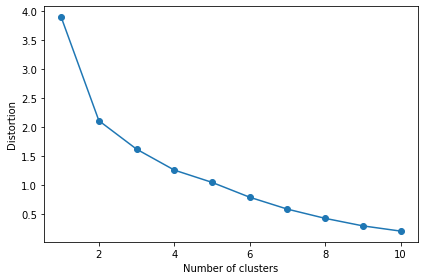

In [44]:
Downtown_Toronto_grouped_clustering = Downtown_Toronto_grouped.drop('Neighborhood', 1)

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(Downtown_Toronto_grouped_clustering)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

Right number of K is 5

In [45]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Downtown_Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 3, 0, 1, 0, 0, 0, 0, 4])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [46]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Downtown_Toronto_merged = D_Toronto_data

# merge Downtown_Toronto_grouped with D_Toronto_data to add latitude/longitude for each neighborhood
Downtown_Toronto_merged = Downtown_Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how ='inner')

Downtown_Toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711,0,Restaurant,Breakfast Spot,Donut Shop,Electronics Store,Intersection,Rental Car Location,Mexican Restaurant,Medical Center,Bank,Fast Food Restaurant
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.692657,-79.264848,0,College Stadium,General Entertainment,Café,Skating Rink,Farm,Farmers Market,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
2,M5C,Downtown Toronto,St. James Town,43.799525,-79.318389,0,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Coffee Shop,Intersection,Camera Store,Nail Salon,Electronics Store,Pharmacy,Pizza Place
4,M5G,Downtown Toronto,Central Bay Street,43.782736,-79.442259,0,Coffee Shop,Supermarket,Grocery Store,Discount Store,Pharmacy,Pizza Place,Falafel Restaurant,Comic Shop,Diner,Donut Shop
5,M6G,Downtown Toronto,Christie,43.753259,-79.329656,3,Park,Food & Drink Shop,Fast Food Restaurant,Yoga Studio,Farm,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant


Let's check for any missing values.

In [47]:
Downtown_Toronto_merged.isnull().sum()

PostalCode                0
Borough                   0
Neighborhood              0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

Finally, let's visualize the resulting clusters

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Downtown_Toronto_merged['Latitude'], Downtown_Toronto_merged['Longitude'], Downtown_Toronto_merged['Neighborhood'], Downtown_Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 5. Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster. 

#### Cluster 1

In [49]:
Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 0, Downtown_Toronto_merged.columns[[1] + list(range(5, Downtown_Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Restaurant,Breakfast Spot,Donut Shop,Electronics Store,Intersection,Rental Car Location,Mexican Restaurant,Medical Center,Bank,Fast Food Restaurant
1,Downtown Toronto,0,College Stadium,General Entertainment,Café,Skating Rink,Farm,Farmers Market,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant
2,Downtown Toronto,0,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Coffee Shop,Intersection,Camera Store,Nail Salon,Electronics Store,Pharmacy,Pizza Place
4,Downtown Toronto,0,Coffee Shop,Supermarket,Grocery Store,Discount Store,Pharmacy,Pizza Place,Falafel Restaurant,Comic Shop,Diner,Donut Shop
7,Downtown Toronto,0,Skating Rink,Park,Spa,Beer Store,Yoga Studio,Farm,Diner,Discount Store,Donut Shop,Electronics Store
8,Downtown Toronto,0,Fast Food Restaurant,Park,Food & Drink Shop,Playground,Italian Restaurant,Light Rail Station,Liquor Store,Gym,Movie Theater,Burrito Place
10,Downtown Toronto,0,Sandwich Place,Bar,Discount Store,Fast Food Restaurant,Museum,Food & Drink Shop,Fish Market,Fish & Chips Shop,Food Truck,College Stadium
11,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Italian Restaurant,Pub,Café,Pizza Place,Indie Movie Theater,Health Food Store,Gym,Grocery Store
12,Downtown Toronto,0,Light Rail Station,Yoga Studio,Fast Food Restaurant,Park,Gym / Fitness Center,Pizza Place,Burrito Place,Farmers Market,Restaurant,Brewery
16,Downtown Toronto,0,Pizza Place,Middle Eastern Restaurant,Intersection,Coffee Shop,Chinese Restaurant,Discount Store,Playground,Sandwich Place,Diner,Donut Shop


#### Cluster 2

In [50]:
Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 1, Downtown_Toronto_merged.columns[[1] + list(range(5, Downtown_Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Downtown Toronto,1,Baseball Field,Yoga Studio,Fast Food Restaurant,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fish & Chips Shop
15,Downtown Toronto,1,Baseball Field,Yoga Studio,Fast Food Restaurant,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fish & Chips Shop


#### Cluster 3

In [51]:
Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 2, Downtown_Toronto_merged.columns[[1] + list(range(5, Downtown_Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Downtown Toronto,2,Clothing Store,Food Truck,Yoga Studio,Farmers Market,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Fast Food Restaurant


#### Cluster 4

In [52]:
Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 3, Downtown_Toronto_merged.columns[[1] + list(range(5, Downtown_Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Downtown Toronto,3,Park,Food & Drink Shop,Fast Food Restaurant,Yoga Studio,Farm,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant


#### Cluster 5

In [53]:
Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 4, Downtown_Toronto_merged.columns[[1] + list(range(5, Downtown_Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Downtown Toronto,4,Airport,Park,Business Service,Comic Shop,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Farmers Market


Disclaimer: This project is part of IBM Data Science Capstone project in Coursera. Some codes for this project are reproduced from previous course materials per instruction for this project.